# Import Library

In [23]:
# load data
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# load/save model
import pickle

### Define common pickle method

In [2]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

#### Constant variable

In [52]:
BOW_FILE_PICKLE = "bow_dictionary.pkl"
SCALER_WS_FILE_PICKLE = "scaler_with_sift.pkl"
SCALER_WOS_FILE_PICKLE = "scaler_without_sift.pkl"
SVM_WS_FILE_PICKLE = "svm_with_sift_model.pkl"
SVM_WOS_FILE_PICKLE = "svm_without_sift_model.pkl"

# Load Data

- input: -
- output: `raw_X, raw_y`

In [4]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [5]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

folder_path = "../Dataset/campuran/" # for local used
# folder_path = "drive/MyDrive/Skripsi/Repos/Dataset/campuran/" # for drive used

for character in hanacaraka:
    dataset_path = folder_path + character

    temp_X, temp_y = import_data(character, dataset_path)

    print("Size of", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Size of ba : 21
Size of ca : 21
Size of da : 21
Size of dha : 21
Size of ga : 21
Size of ha : 21
Size of ja : 21
Size of ka : 21
Size of la : 21
Size of ma : 21
Size of na : 21
Size of nga : 21
Size of nya : 21
Size of pa : 21
Size of ra : 21
Size of sa : 21
Size of ta : 21
Size of tha : 21
Size of wa : 21
Size of ya : 21


In [6]:
# Ukuran keseluruhan data
print("Number of data:", raw_X.shape[0])
print("Image dimension:", raw_X[0].shape)

Number of data: 420
Image dimension: (224, 224, 3)


### Visualize Raw Data

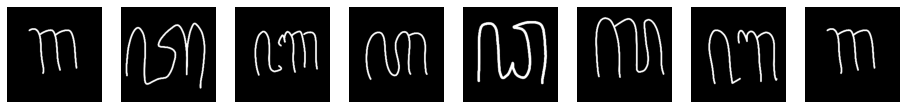

In [7]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[np.random.randint(0, raw_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

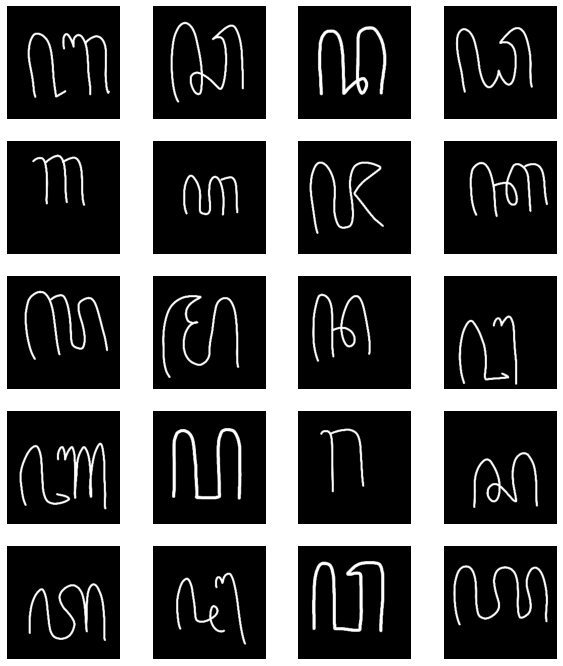

In [8]:
fig = plt.figure(figsize=(10, 12))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[i*20, :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Augmantation & Preparation Data

- input: `raw_X, raw_y`
- output: `X, y`

List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

List Preprocessing :
1. Resizing (192x192)
2. Grayscaling
3. Equalization

### Augmented Method

In [9]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

### Image Preprocessing Method

In [10]:
# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [11]:
# Generate augmentation and preprocessing data
size = 192
def dataset_aug_generator_prep(ori_img, size):
    ori_img = resizing(ori_img, size)
    ori_img = grayscaling(ori_img)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
    for idx, item_img in enumerate(result_aug):
        result_aug[idx] = equalizing(result_aug[idx])
    return result_aug

#### test result image after generate augmentation and preprocessing

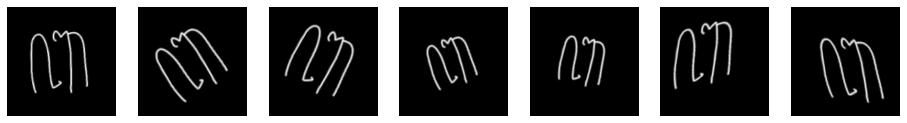

In [12]:
test_img_aug = dataset_aug_generator_prep(raw_X[0], size)

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

## Generate Aug & Prep Image on All Raw Data

In [13]:
X = np.empty((0, size, size), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img, size)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [14]:
print("Result X data dimension:", X.shape)
print("Result y data dimension:", y.shape)

Result X data dimension: (2940, 192, 192)
Result y data dimension: (2940,)


### Visualize Result Data

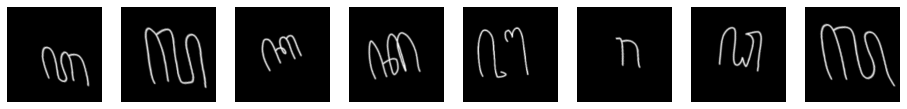

In [15]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract SIFT Descriptors 

In [16]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [17]:
image_descriptors = extract_sift_features(X)

In [18]:
all_descriptors = split_all_descriptors(image_descriptors)
print("Number of keypoint descriptor:", all_descriptors.shape)

Number of keypoint descriptor: (193416, 128)


### Create BOW of Descriptor Using Cluster

In [19]:
def kmeans_bow(all_descriptors, num_cluster):
    if not os.path.isfile(BOW_FILE_PICKLE):
        kmeans = KMeans(n_clusters = num_cluster, verbose=1)
        kmeans.fit(all_descriptors)

        bow_dict = kmeans.cluster_centers_
        
        save_file_pickle(bow_dict, BOW_FILE_PICKLE)
    else:
        bow_dict = load_file_pickle(BOW_FILE_PICKLE)

    return bow_dict

In [20]:
num_cluster = 750
bow = kmeans_bow(all_descriptors, num_cluster)

### Create Features From BOW

In [21]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [22]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 750)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [24]:
# normalization
scaler = MinMaxScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [25]:
# Just save normalization function for future used
save_file_pickle(scaler, SCALER_WS_FILE_PICKLE)

In [26]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'scale', 0.001, 0.0015, 0.0025, 0.003 \]
    - 'scale' = 1 / nfeatures * x.var()

#### Load model

In [27]:
# Just load model without re-training if you want
svm_ws = load_file_pickle(SVM_WS_FILE_PICKLE)

In [32]:
# check variance data train
print(X_train.var())
print(1 / (750 * X_train.var()))

0.012748508063733737
0.10458740165261593


In [33]:
svm_ws_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['scale', 0.05, 0.08, 0.12, 0.15]
}
svm_ws = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_ws_params, cv=5, verbose=3)

In [34]:
svm_ws.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..................C=1, gamma=scale;, score=0.896 total time=   7.9s
[CV 2/5] END ..................C=1, gamma=scale;, score=0.892 total time=   7.8s
[CV 3/5] END ..................C=1, gamma=scale;, score=0.928 total time=   8.0s
[CV 4/5] END ..................C=1, gamma=scale;, score=0.896 total time=   8.3s
[CV 5/5] END ..................C=1, gamma=scale;, score=0.910 total time=   8.3s
[CV 1/5] END ...................C=1, gamma=0.05;, score=0.884 total time=   7.6s
[CV 2/5] END ...................C=1, gamma=0.05;, score=0.892 total time=   7.0s
[CV 3/5] END ...................C=1, gamma=0.05;, score=0.906 total time=   7.0s
[CV 4/5] END ...................C=1, gamma=0.05;, score=0.892 total time=   7.1s
[CV 5/5] END ...................C=1, gamma=0.05;, score=0.906 total time=   7.0s
[CV 1/5] END ...................C=1, gamma=0.08;, score=0.892 total time=   7.5s
[CV 2/5] END ...................C=1, gamma=0.08

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['scale', 0.05, 0.08, 0.12, 0.15]},
             verbose=3)

In [35]:
print("Best Model:", svm_ws.best_estimator_)
print("Best CV Score:", svm_ws.best_score_)

Best Model: SVC(C=3, gamma=0.05, probability=True)
Best CV Score: 0.9215711422845692


#### All result score CV from tuning parameter SVM

In [36]:
cv_results_df = pd.DataFrame(svm_ws.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
3_0.05,"{'C': 3, 'gamma': 0.05}",1,0.921571,0.009480
6_0.08,"{'C': 6, 'gamma': 0.08}",2,0.921570,0.007822
15_0.08,"{'C': 15, 'gamma': 0.08}",3,0.921170,0.008042
10_0.08,"{'C': 10, 'gamma': 0.08}",3,0.921170,0.008042
3_0.08,"{'C': 3, 'gamma': 0.08}",5,0.920770,0.007839
6_0.05,"{'C': 6, 'gamma': 0.05}",6,0.919969,0.007367
6_scale,"{'C': 6, 'gamma': 'scale'}",7,0.919969,0.009873
10_0.05,"{'C': 10, 'gamma': 0.05}",8,0.919968,0.006694
10_scale,"{'C': 10, 'gamma': 'scale'}",9,0.919568,0.009829


#### Save model

In [37]:
# Just save model for future used
save_file_pickle(svm_ws, SVM_WS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=3, gamma=0.0009)

In [38]:
y_pred = svm_ws.predict(X_test)

In [39]:
test = svm_ws.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[6.94372826e-04, 4.26057965e-02, 1.12789698e-03, 5.94681790e-04,
        9.70270528e-05, 4.68107219e-04, 2.75976316e-04, 1.22440811e-03,
        5.25123579e-04, 3.60079828e-04, 2.54997635e-03, 2.37403076e-04,
        1.45777583e-03, 8.12331782e-05, 1.89116645e-05, 9.43823841e-01,
        3.39685803e-04, 2.40130315e-03, 1.65680359e-04, 9.50719791e-04]])

In [40]:
test_label = hanacaraka[test.argmax()]
test_label


'sa'

In [41]:
test_acc = round(test.max() * 100, 2)
test_acc

94.38

#### Heatmap result predict

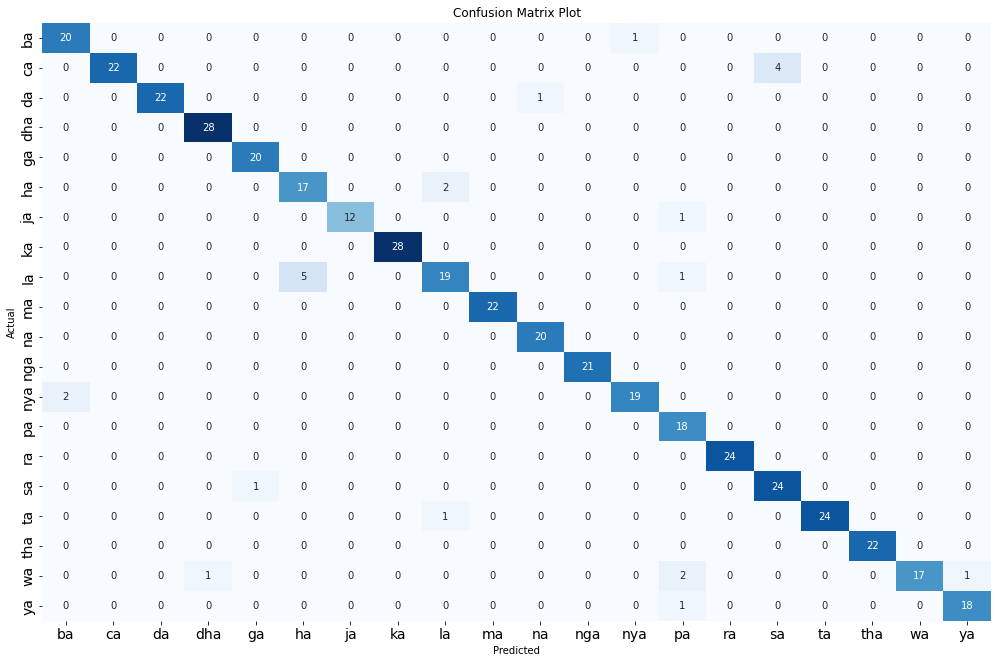

In [42]:
conf_ws = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_ws, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [43]:
class_rep_ws = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_ws)

Classification report result:
              precision    recall  f1-score   support

          ba       0.91      0.95      0.93        21
          ca       1.00      0.85      0.92        26
          da       1.00      0.96      0.98        23
         dha       0.97      1.00      0.98        28
          ga       0.95      1.00      0.98        20
          ha       0.77      0.89      0.83        19
          ja       1.00      0.92      0.96        13
          ka       1.00      1.00      1.00        28
          la       0.86      0.76      0.81        25
          ma       1.00      1.00      1.00        22
          na       0.95      1.00      0.98        20
         nga       1.00      1.00      1.00        21
         nya       0.95      0.90      0.93        21
          pa       0.78      1.00      0.88        18
          ra       1.00      1.00      1.00        24
          sa       0.86      0.96      0.91        25
          ta       1.00      0.96      0.98        

### Result Accuracy Score for SVM with SIFT

In [44]:
acc_ws = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_ws)

Accuracy score: 0.9455782312925171


# Note for Result SIFT With SVM

### Testing Scenario
- Img = \[ 64, 96, 128, 164, 192, 224 \]
  - Img prep = Greyscale, Equalization
- K = \[ 1000, 700, 500, 350, 240, 180 \]
- C = \[ 1, 3, 6, 10, 15\]
- G = \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]

### Result:
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (64,64), K = 240, SVM = .89:.90
- Img = (96,96), K = 240, SVM = .89:.89
- Img = (128,128), K = 140, SVM = .87:.89
- Img = (128,128), K = 180, SVM = .88:.93
- Img = (128,128), K = 240, SVM = .90:.95
- Img = (128,128), K = 350, SVM = .91:.94
- Img = (128,128), K = 500, SVM = .92:.95
- Img = (128,128), K = 700, SVM = .92:.94
- Img = (128,128), K = 1000, SVM = .92:.94
- Img = (164,164), K = 240, SVM = .90:.91
- Img = (192,192), K = 240, SVM = .90:.92
- Img = (224,224), K = 240, SVM = .88:.90


======================================

- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T) / 0.86 (G,T,E)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96 (G,T) / 0.90:0.94 (G,E)
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95


### Conclusion
- Best image : 128x128
  1. 128: .90:.94
  2. 192: .90:.92
  3. 164: .90:.91
  4. 64: .89:.90
  5. 96: .89:.89
  6. 224: .88:.90
- Best K val : 500 
  1. 500 : .92:.95
  2. 240 : .90:.95
  3. 700 : .92:.94
  4. 1000 : .92:.94
  5. 350 : .91:.94
  6. 180 : .88:.93
- Best C val : 6
- Best G val : 0.0015

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

Data should be resized for lower time consumtion training

In [47]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(equalizing(resizing(X[i], 32)))
    
new_X = np.array(new_X, dtype=np.uint8)

### Visualize Result Data

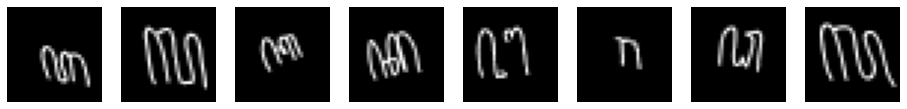

In [48]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(new_X[np.random.randint(0, new_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

### Preprocessing

In [49]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 1024)


In [54]:
# normalization
scaler = MinMaxScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [55]:
# Just save normalization function for future used
save_file_pickle(scaler, SCALER_WOS_FILE_PICKLE)

In [56]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'scale', 0.0008, 0.001, 0.0015, 0.0018 \]
    - 'scale' = 1 / nfeatures * x.var()

#### Load model

In [57]:
# Just load model without re-training if you want
svm_wos = load_file_pickle(SVM_WOS_FILE_PICKLE)

In [59]:
# check variance data train
print(X_train.var())
print(1 / (1024 * X_train.var()))

0.041400309431417606
0.023588289880242114


In [61]:
svm_wos_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['scale', 0.018, 0.021, 0.025, 0.028],
}
svm_wos = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wos_params, cv=5, verbose=3)

In [62]:
svm_wos.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..................C=1, gamma=scale;, score=0.446 total time=  11.9s
[CV 2/5] END ..................C=1, gamma=scale;, score=0.456 total time=  10.7s
[CV 3/5] END ..................C=1, gamma=scale;, score=0.434 total time=  10.5s
[CV 4/5] END ..................C=1, gamma=scale;, score=0.446 total time=  10.5s
[CV 5/5] END ..................C=1, gamma=scale;, score=0.453 total time=  10.5s
[CV 1/5] END ..................C=1, gamma=0.018;, score=0.422 total time=  10.2s
[CV 2/5] END ..................C=1, gamma=0.018;, score=0.442 total time=  10.2s
[CV 3/5] END ..................C=1, gamma=0.018;, score=0.422 total time=  10.2s
[CV 4/5] END ..................C=1, gamma=0.018;, score=0.458 total time=  10.2s
[CV 5/5] END ..................C=1, gamma=0.018;, score=0.445 total time=  10.3s
[CV 1/5] END ..................C=1, gamma=0.021;, score=0.434 total time=  10.4s
[CV 2/5] END ..................C=1, gamma=0.021

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['scale', 0.018, 0.021, 0.025, 0.028]},
             verbose=3)

In [63]:
print("Best Model:", svm_wos.best_estimator_)
print("Best CV Score:", svm_wos.best_score_)

Best Model: SVC(C=6, gamma=0.021, probability=True)
Best CV Score: 0.5122092184368737


#### All result score CV from tuning parameter SVM

In [64]:
cv_results_df = pd.DataFrame(svm_wos.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
6_0.021,"{'C': 6, 'gamma': 0.021}",1,0.512209,0.013956
6_0.018,"{'C': 6, 'gamma': 0.018}",2,0.512208,0.015161
15_0.018,"{'C': 15, 'gamma': 0.018}",3,0.511806,0.014649
15_0.021,"{'C': 15, 'gamma': 0.021}",4,0.511409,0.014059
10_0.021,"{'C': 10, 'gamma': 0.021}",4,0.511409,0.014059
10_0.018,"{'C': 10, 'gamma': 0.018}",6,0.511406,0.014989
3_0.021,"{'C': 3, 'gamma': 0.021}",7,0.511008,0.012336
3_0.018,"{'C': 3, 'gamma': 0.018}",8,0.510610,0.013803
3_scale,"{'C': 3, 'gamma': 'scale'}",9,0.510208,0.011041


#### Save model

In [66]:
# Just save model for future used
save_file_pickle(svm_wos, SVM_WOS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=10, gamma=0.0015)

In [67]:
y_pred = svm_wos.predict(X_test)

In [68]:
test = svm_wos.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[0.03116954, 0.25289614, 0.02635285, 0.31838433, 0.00086402,
        0.0064036 , 0.00751487, 0.00312581, 0.00746639, 0.00639479,
        0.00316407, 0.03514575, 0.00561219, 0.02013861, 0.0006664 ,
        0.04172358, 0.01123267, 0.12887283, 0.08986697, 0.00300458]])

#### Heatmap result predict

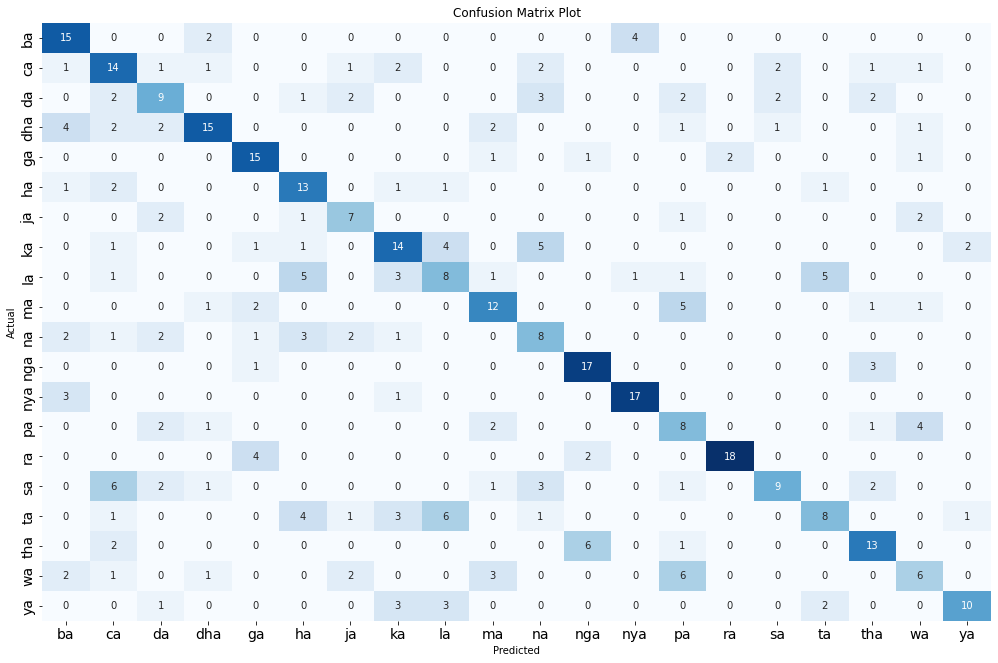

In [69]:
conf_wos = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_wos, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [70]:
class_rep_wos = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_wos)

Classification report result:
              precision    recall  f1-score   support

          ba       0.54      0.71      0.61        21
          ca       0.42      0.54      0.47        26
          da       0.43      0.39      0.41        23
         dha       0.68      0.54      0.60        28
          ga       0.62      0.75      0.68        20
          ha       0.46      0.68      0.55        19
          ja       0.47      0.54      0.50        13
          ka       0.50      0.50      0.50        28
          la       0.36      0.32      0.34        25
          ma       0.55      0.55      0.55        22
          na       0.36      0.40      0.38        20
         nga       0.65      0.81      0.72        21
         nya       0.77      0.81      0.79        21
          pa       0.31      0.44      0.36        18
          ra       0.90      0.75      0.82        24
          sa       0.64      0.36      0.46        25
          ta       0.50      0.32      0.39        

### Result Accuracy Score for SVM without SIFT

In [71]:
acc_wos = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_wos)

Accuracy score: 0.5351473922902494


# Note for Result SVM Without WIFT

### Result:

- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45

# SVM With SIFT vs SVM Without SIFT Comparison

In [72]:
compare_df = pd.DataFrame({"Model_SVM": ["Without SIFT", "With SIFT"],
                          "Accuracy": [acc_wos, acc_ws]})

compare_df

,Model_SVM,Accuracy
0,Without SIFT,0.535147
1,With SIFT,0.945578


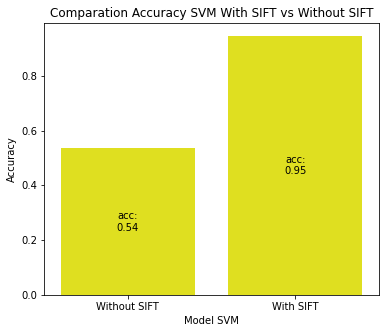

In [73]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With SIFT vs Without SIFT")

plt.show()

# Predict From Input File

In [53]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

# Load file ==================================================================================
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image
# ============================================================================================
# Preprocessing Image ========================================================================
def equalizing(img):
    img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

def prep_image(image):
    img = resizing(image, 128)
    img = grayscaling(img)
    img = equalizing(img)
    return img
# ============================================================================================
# Feature Extraction =========================================================================
def extract_sift_descriptor(image):
    sift = cv2.SIFT_create()
    _, descriptor = sift.detectAndCompute(image, None)
    return descriptor

def create_feature_bow(image_descriptor, bow, num_cluster):
    features = np.array([0] * num_cluster, dtype=float)

    if image_descriptor is not None:
        distance = cdist(image_descriptor, bow)
        argmin = np.argmin(distance, axis = 1)
        
        for j in argmin:
            features[j] += 1.0

    return np.array(features)

def extract_feature(image):
    img_descriptor = extract_sift_descriptor(image)
    
    num_cluster = 500
    bow = load_file_pickle(BOW_FILE_PICKLE)
    
    img_feature = create_feature_bow(img_descriptor, bow, num_cluster)
    return img_feature
# ============================================================================================
# Prediction Process =========================================================================
def predict_image(feature):
    scaler = load_file_pickle(SCALER_WS_FILE_PICKLE)
    feature_scale = scaler.transform([feature])
    
    svm_model = load_file_pickle(SVM_WS_FILE_PICKLE)
    result_predict = svm_model.predict(feature_scale)
    return result_predict
# ============================================================================================
# Open widget laod file ======================================================================
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() 
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    b.files = filedialog.askopenfilename(multiple=True) 
    print(b.files[0])
    processing_files(b.files[0])
# ============================================================================================
# Open widget laod file ======================================================================
def processing_files(file):
    img = import_image(file)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    img = prep_image(img)
    
    img_feature = extract_feature(img)
    result_predict = predict_image(img_feature)
    print("Result Class Prediction :", result_predict)
# ============================================================================================

fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

Button(description='File select', style=ButtonStyle())